In [1]:
!pip install vit-keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, Model, metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score
from vit_keras import vit, utils

In [3]:
# Helper Functions

def get_binary_testset(dataset_name):
    """
    dataset_name -> trainset, valset, testset
    """
    trainset, valset, testset = None, None, None
    dataset_name = dataset_name.lower()
    path_2_root = "../.."

    if not "oc" in dataset_name:
        if "dar" in dataset_name and "oc" not in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/train_test"
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/validation"

        if "avg" in dataset_name: # Celeb-avg-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_avg"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_avg"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_avg"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_avg"

        elif "rnd" in dataset_name: # Celeb-rnd-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_rnd"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_rnd"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_rnd"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_rnd"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_rnd"

        elif "diff" in dataset_name: # Celeb-diff-30
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30"
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30-test"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

    else: # oc
        if "dar" in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/real-train/" # unary
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/realfake-test/" # binary

        elif "avg" in dataset_name:
            pass

        elif "rnd" in dataset_name: # Celeb-rnd-30-OC
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-train/" # unary
            valset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-val/"  # unary
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/" # binary

    testset = trainset if testset==None else testset
    valset = trainset if valset==None else valset
    return trainset, valset, testset


In [4]:
dataset_name = "Celeb-rnd-30-train"
DATASET, VAL_DATASET, TEST_DATASET = get_binary_testset(dataset_name)

BATCH_SIZE = 64
SEED = 42
# IMAGE_SIZE = 7*16 #112x112 (IMAGE_SIZE % == 0 = True, because patches)
IMAGE_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 1e-3

DATASET, VAL_DATASET, TEST_DATASET

('../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30',
 '../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30',
 '../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test')

In [5]:
IMG_DATAGEN = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=vit.preprocess_inputs,
)

GEN = IMG_DATAGEN.flow_from_directory(
    DATASET,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    subset="training",
    class_mode="binary",
    )

VAL_GEN = None
has_test_set = TEST_DATASET != DATASET
if has_test_set:
    VAL_GEN = IMG_DATAGEN.flow_from_directory(
        VAL_DATASET,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed=SEED,
        subset="validation",
        class_mode="binary",
        )

# SPECIFY VAL SPLIT IN FIT FUNC
TEST_GEN = IMG_DATAGEN.flow_from_directory(
    TEST_DATASET,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    subset=None if has_test_set else "validation", # there no test set 
    class_mode="binary",
    )



Found 44393 images belonging to 2 classes.
Found 11097 images belonging to 2 classes.
Found 19638 images belonging to 2 classes.


In [6]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    # Some code is taken from:
    # https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [7]:
total_steps = int((GEN.n//GEN.batch_size) * EPOCHS)
warmup_epoch_percentage = 0.2
warmup_steps = int(total_steps * warmup_epoch_percentage)
SCHEDULED_LRS = WarmUpCosine(learning_rate_base=LEARNING_RATE,
                             total_steps=total_steps,
                             warmup_learning_rate=0,
                             warmup_steps=warmup_steps)
# lrs = [SCHEDULED_LRS(step) for step in range(total_steps)]
# plt.plot(lrs)
# plt.title("Learning Rate Schedule")
# plt.xlabel("Step", fontsize=14)
# plt.ylabel("LR", fontsize=14)
# plt.show()

EARLY_STOP = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=EPOCHS//10,
    verbose=1,
    restore_best_weights=True,
    )

path_2_weights_dir = f"../../_WEIGHTS/vit/{dataset_name}_E{EPOCHS}"
MODEL_CHECKPOINT = ModelCheckpoint(
    filepath = path_2_weights_dir, 
    mode='max', 
    monitor='val_auc', 
    save_freq='epoch',
    verbose=1, 
    save_best_only=True,
    save_weights_only=True,
    )

In [8]:
PRE_TRAINED_MODEL = vit.vit_b16(
    image_size=IMAGE_SIZE,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

for layer in PRE_TRAINED_MODEL.layers:
    layer.trainable = False

x = layers.Flatten()(PRE_TRAINED_MODEL.output)
# x = layers.BatchNormalization()(x)
# x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

VIT_FE = Model(PRE_TRAINED_MODEL.input, x) # Vision Transformer Feature Extractor

VIT_FE.compile(
    optimizer = keras.optimizers.SGD(learning_rate=SCHEDULED_LRS, momentum=0.9),
    loss = 'binary_crossentropy',
    metrics = [metrics.AUC(name = 'auc')])
VIT_FE.summary()

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 256, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 257, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 257, 768)         197376    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 257, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))        

In [9]:
VIT_FE.load_weights(path_2_weights_dir)
path_2_weights_dir

'../../_WEIGHTS/vit/Celeb-rnd-30-train_E100'

100%|██████████| 306/306 [04:40<00:00,  1.09it/s]


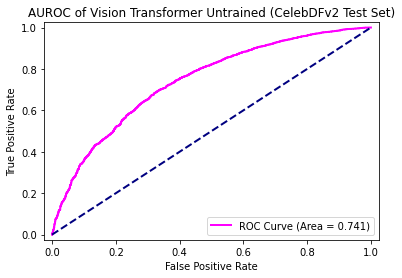

In [10]:
EVAL_GEN = TEST_GEN
y_pred = []
y_true = []
for b, (X, y) in tqdm(enumerate(EVAL_GEN), total=len(EVAL_GEN)-1):
    y_pred += VIT_FE.predict(X).tolist() 
    y_true += y.tolist()
    # break
    if b >= (EVAL_GEN.samples / EVAL_GEN.batch_size) - 1:
        break

experiment_name = "Vision Transformer Untrained (CelebDFv2 Test Set)"
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_rint = np.rint(y_pred)

# Get AUC
auroc = roc_auc_score(y_true, y_pred)
fpr, tpr, _  = roc_curve(y_true, y_pred)

# If model is worse than random but so much worse that, it's predicting the opposite way
if auroc < .5:
    auroc = 1 - auroc
    fpr, tpr = tpr, fpr
    y_pred = np.ones(y_pred.shape) - y_pred

# Get F1, Precision and Recall
f1 = f1_score(y_true, y_pred_rint)
prec = precision_score(y_true, y_pred_rint)
recall = recall_score(y_true, y_pred_rint)

# Plot AUC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
extra_xylim = 0.025
plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"AUROC of {experiment_name}")
plt.legend(loc="lower right")
# plt.savefig(f"{fname}.png") # Save AUC fig
plt.show()

In [11]:
VAL_GEN = TEST_GEN # CHANGE THISSSS
history = VIT_FE.fit(
    GEN,
    validation_data = VAL_GEN, 
    epochs = EPOCHS,
    verbose = 1,
    callbacks = [
        EARLY_STOP,
        MODEL_CHECKPOINT,
    ]
    )

Epoch 1/100
694/694 [==============================] - ETA: 0s - loss: 0.2900 - auc: 0.7385
Epoch 1: val_auc improved from -inf to 0.75677, saving model to ../../_WEIGHTS/vit\Celeb-rnd-30-train_E100
694/694 [==============================] - 763s 1s/step - loss: 0.2900 - auc: 0.7385 - val_loss: 0.2484 - val_auc: 0.7568
Epoch 2/100
694/694 [==============================] - ETA: 0s - loss: 0.2847 - auc: 0.7527
Epoch 2: val_auc improved from 0.75677 to 0.76522, saving model to ../../_WEIGHTS/vit\Celeb-rnd-30-train_E100
694/694 [==============================] - 513s 739ms/step - loss: 0.2847 - auc: 0.7527 - val_loss: 0.2461 - val_auc: 0.7652
Epoch 3/100
694/694 [==============================] - ETA: 0s - loss: 0.2817 - auc: 0.7601
Epoch 3: val_auc improved from 0.76522 to 0.77270, saving model to ../../_WEIGHTS/vit\Celeb-rnd-30-train_E100
694/694 [==============================] - 514s 740ms/step - loss: 0.2817 - auc: 0.7601 - val_loss: 0.2438 - val_auc: 0.7727
Epoch 4/100
694/694 [====

In [ ]:
plt.plot(history.history['loss'])

plt.title('ViT Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'mae'], loc='center right')
plt.show()

plt.plot(history.history['val_loss'])
plt.title('ViT Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_mae'], loc='upper right')
plt.show()

EVAL_GEN = TEST_GEN
y_pred = []
y_true = []
for b, (X, y) in tqdm(enumerate(EVAL_GEN), total=len(EVAL_GEN)-1):
    y_pred += VIT_FE.predict(X).tolist() 
    y_true += y.tolist()
    # break
    if b >= (EVAL_GEN.samples / EVAL_GEN.batch_size) - 1:
        break

experiment_name = "Vision Transformer Trained (CelebDFv2 Test Set)"
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_rint = np.rint(y_pred)

# Get AUC
auroc = roc_auc_score(y_true, y_pred)
fpr, tpr, _  = roc_curve(y_true, y_pred)

# If model is worse than random but so much worse that, it's predicting the opposite way
if auroc < .5:
    auroc = 1 - auroc
    fpr, tpr = tpr, fpr
    y_pred = np.ones(y_pred.shape) - y_pred

# Get F1, Precision and Recall
f1 = f1_score(y_true, y_pred_rint)
prec = precision_score(y_true, y_pred_rint)
recall = recall_score(y_true, y_pred_rint)

# Plot AUC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
extra_xylim = 0.025
plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"AUROC of {experiment_name}")
plt.legend(loc="lower right")
# plt.savefig(f"{fname}.png") # Save AUC fig
plt.show()

NameError: name 'history' is not defined

In [ ]:
train_gen_list = list(GEN.classes)
val_gen_list = list(VAL_GEN.classes)

train_neg, train_pos = train_gen_list.count(0), train_gen_list.count(1)
val_neg, val_pos = val_gen_list.count(0), val_gen_list.count(1)

pos = train_pos + val_pos
neg = train_neg + val_neg
total = pos + neg

weight_for_0 = (1.0 / neg)*(total)/2.0 
weight_for_1 = (1.0 / pos)*(total)/2.0

CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
print(f'Class weights = {CLASS_WEIGHT}')

VIT_FE.compile(
    optimizer=keras.optimizers.SGD(learning_rate=SCHEDULED_LRS, momentum=0.9),
    loss='binary_crssentropy',
    metrics=[metrics.AUC(name='auc')]) # recompile for WarmUpCosine SCHEDULED_LRS

history = VIT_FE.fit(
    GEN,
    validation_data = VAL_GEN,
    epochs = EPOCHS,
    verbose = 1,
    class_weight = CLASS_WEIGHT,
    callbacks = [
        EARLY_STOP,
        MODEL_CHECKPOINT,
    ]
    )

Epoch 1/10
694/694 [==============================] - ETA: 0s - loss: 0.6744 - auc: 0.6924
Epoch 1: val_auc improved from -inf to 0.64716, saving model to ../../_WEIGHTS/vit\E10
694/694 [==============================] - 104s 144ms/step - loss: 0.6744 - auc: 0.6924 - val_loss: 0.6654 - val_auc: 0.6472
Epoch 2/10
694/694 [==============================] - ETA: 0s - loss: 0.6262 - auc: 0.7108
Epoch 2: val_auc improved from 0.64716 to 0.65094, saving model to ../../_WEIGHTS/vit\E10
694/694 [==============================] - 101s 146ms/step - loss: 0.6262 - auc: 0.7108 - val_loss: 0.6397 - val_auc: 0.6509
Epoch 3/10
694/694 [==============================] - ETA: 0s - loss: 0.6275 - auc: 0.7103
Epoch 3: val_auc did not improve from 0.65094
694/694 [==============================] - 96s 138ms/step - loss: 0.6275 - auc: 0.7103 - val_loss: 0.6480 - val_auc: 0.6494
Epoch 4/10
694/694 [==============================] - ETA: 0s - loss: 0.6274 - auc: 0.7089
Epoch 4: val_auc improved from 0.65094 

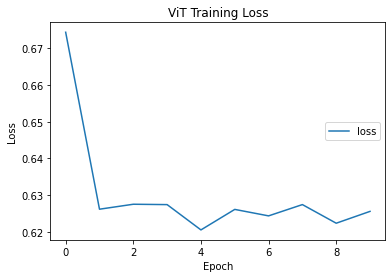

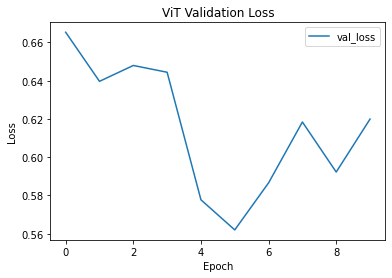

100%|██████████| 867/867 [02:34<00:00,  5.60it/s]


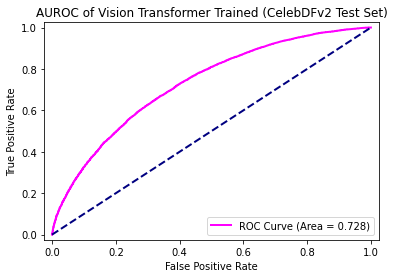

In [ ]:
plt.plot(history.history['loss'])

plt.title('ViT Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'mae'], loc='center right')
plt.show()

plt.plot(history.history['val_loss'])
plt.title('ViT Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_mae'], loc='upper right')
plt.show()

EVAL_GEN = TEST_GEN
y_pred = []
y_true = []
for b, (X, y) in tqdm(enumerate(EVAL_GEN), total=len(EVAL_GEN)-1):
    y_pred += VIT_FE.predict(X).tolist() 
    y_true += y.tolist()
    # break
    if b >= (EVAL_GEN.samples / EVAL_GEN.batch_size) - 1:
        break

experiment_name = "Vision Transformer Trained (CelebDFv2 Test Set)"
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_rint = np.rint(y_pred)

# Get AUC
auroc = roc_auc_score(y_true, y_pred)
fpr, tpr, _  = roc_curve(y_true, y_pred)

# If model is worse than random but so much worse that, it's predicting the opposite way
if auroc < .5:
    auroc = 1 - auroc
    fpr, tpr = tpr, fpr
    y_pred = np.ones(y_pred.shape) - y_pred

# Get F1, Precision and Recall
f1 = f1_score(y_true, y_pred_rint)
prec = precision_score(y_true, y_pred_rint)
recall = recall_score(y_true, y_pred_rint)

# Plot AUC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
extra_xylim = 0.025
plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"AUROC of {experiment_name}")
plt.legend(loc="lower right")
# plt.savefig(f"{fname}.png") # Save AUC fig
plt.show()